In [1]:
# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Wang, Z., Yan, W., & Oates, T. (2017, May). Time series classification from scratch with deep neural networks: A strong baseline. In 2017 international joint conference on neural networks (IJCNN) (pp. 1578-1585). IEEE.

# Fawaz, H. I., Forestier, G., Weber, J., Idoumghar, L., & Muller, P. A. (2019). Deep learning for time series classification: a review. Data Mining and Knowledge Discovery, 33(4), 917-963.
# Official ResNet TensorFlow implementation: https://github.com/hfawaz/dl-4-tsc

# 👀 kernel filter size 8 has been replaced by 7 (I believe it's a bug)

from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from models.layers import *



class SeModule(nn.Module):
    def __init__(self, ch, reduction, act_fn='relu'):
        super().__init__()
        nf = math.ceil(ch//reduction/8)*8 + 1
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = convlayer(ch, nf, 1, act_fn=act_fn)
        self.conv2 = convlayer(nf, ch, 1, act_fn=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        res = self.pool(x)
        res = self.conv1(res)
        res = self.conv2(res)
        res = self.sigmoid(res)
        return x * res
    
    
def _conv1d_spect(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

class SelfAttention(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.query,self.key,self.value = [convlayer(n_channels, c, 1, act_fn=False, bias=False) for c in (n_channels//8,n_channels//8,n_channels)]
        self.gamma = nn.Parameter(tensor([0.]))
        
    def forward(self, x):
        #Notation from the paper.
        size = x.size()
        x = x.view(*size[:2],-1)
        f,g,h = self.query(x),self.key(x),self.value(x)
        beta = F.softmax(torch.bmm(f.transpose(1,2), g), dim=1)
        o = self.gamma * torch.bmm(h, beta) + x
        return o.view(*size).contiguous()
    
class SimpleSelfAttention(nn.Module):
    def __init__(self, n_in:int, ks=1, sym=False):
        super().__init__()
        self.sym,self.n_in = sym,n_in
        self.conv = _conv1d_spect(n_in, n_in, ks, padding=ks//2, bias=False)
        self.gamma = nn.Parameter(torch.tensor([0.]))

    def forward(self,x):
        if self.sym:
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)

        size = x.size()
        x = x.view(*size[:2],-1)
        convx = self.conv(x)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())
        o = torch.bmm(xxT, convx)
        o = self.gamma * o + x
        return o.view(*size).contiguous()
        
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=[7, 5, 3], act_fn='relu'):
        super().__init__()
        self.conv1 = convlayer(ni, nf, ks[0], act_fn=act_fn)
        self.conv2 = convlayer(nf, nf, ks[1], act_fn=act_fn)
        self.conv3 = convlayer(nf, nf, ks[2], act_fn=False, zero_bn=True)
        self.se = SeModule(nf, 16)
        self.sa = SelfAttention(nf)
        # expand channels for the sum if necessary
        self.shortcut = noop if ni == nf else convlayer(ni, nf, ks=1, act_fn=False)
        self.act_fn = get_act_layer(act_fn)

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Squeeze and Excitation
        x = self.se(x)
#         print(x.shape)

        # Self Attention
#         x = self.sa(x)
        # Shortcut
        sc = self.shortcut(res)
        # Residual
        x += sc
        x = self.act_fn(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self,c_in, c_out, nf = 64, pool=nn.AdaptiveAvgPool1d, act_fn='relu'):
        super().__init__()
        
#         self.prep = convlayer(c_in, nf, 7, act_fn=False, dilation=1)
        self.block1 = ResBlock(c_in, nf, ks=[7, 5, 3], act_fn=act_fn)
        self.block2 = ResBlock(nf, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.block3 = ResBlock(nf * 2, nf * 2, ks=[7, 5, 3], act_fn=act_fn)
        self.gap = pool(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
#         x = self.prep(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).squeeze(-1)
        return self.fc(x)

/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J., ... & Petitjean, F. (2019). InceptionTime: Finding AlexNet for Time Series Classification. arXiv preprint arXiv:1909.04939.
# Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime

def noop(x):
    return x

def shortcut(c_in, c_out):
    return nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1), 
                           nn.BatchNorm1d(c_out)])
    
class Inception(nn.Module):
    def __init__(self, c_in, bottleneck=32, ks=40, nb_filters=32):

        super().__init__()
        self.bottleneck = nn.Conv1d(c_in, bottleneck, 1) if bottleneck and c_in > 1 else noop
        mts_feat = bottleneck or c_in
        conv_layers = []
        kss = [ks // (2**i) for i in range(3)]
        # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch 1.3
        kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss]  
        for i in range(len(kss)):
            conv_layers.append(
                nn.Conv1d(mts_feat, nb_filters, kernel_size=kss[i], padding=kss[i] // 2))
        self.conv_layers = nn.ModuleList(conv_layers)
        self.maxpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv = nn.Conv1d(c_in, nb_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(nb_filters * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        for i in range(3):
            out_ = self.conv_layers[i](x)
            if i == 0: out = out_
            else: out = torch.cat((out, out_), 1)
        mp = self.conv(self.maxpool(input_tensor))
        inc_out = torch.cat((out, mp), 1)
        return self.act(self.bn(inc_out))


class InceptionBlock(nn.Module):
    def __init__(self,c_in,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):

        super().__init__()

        self.residual = residual
        self.depth = depth

        #inception & residual layers
        inc_mods = []
        res_layers = []
        se_layers = []
        res = 0
        for d in range(depth):
            inc_mods.append(
                Inception(c_in if d == 0 else nb_filters * 4, bottleneck=bottleneck if d > 0 else 0,ks=ks,
                          nb_filters=nb_filters))
            se_layers.append(SeModule(c_in if d == 0 else nb_filters * 4, 16))
            if self.residual and d % 3 == 2:
                res_layers.append(shortcut(c_in if res == 0 else nb_filters * 4, nb_filters * 4))
                res += 1
            else: 
                res_layer = res_layers.append(None)
                
        self.inc_mods = nn.ModuleList(inc_mods)
        self.res_layers = nn.ModuleList(res_layers)
        self.se_layers = nn.ModuleList(se_layers)
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.se_layers[d](x)
            x = self.inc_mods[d](x)
            if self.residual and d % 3 == 2:
                res = self.res_layers[d](res)
                x += res
                res = x
                x = self.act(x)
        return x
    
class InceptionTime(nn.Module):
    def __init__(self,c_in,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        super().__init__()
        self.block = InceptionBlock(c_in,bottleneck=bottleneck,ks=ks,nb_filters=nb_filters,
                                    residual=residual,depth=depth)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nb_filters * 4, c_out)

    def forward(self, x):
        x = self.block(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [3]:
x = torch.randn((32,3,4096))
size = x.size()
r = int(math.sqrt(size[-1]))
x = x.view(*size[:2],-1)
x.shape

torch.Size([32, 3, 4096])

In [4]:
conv = _conv1d_spect(3, 3, 1, padding=1//2, bias=False)
convx = conv(x)
convx.shape

torch.Size([32, 3, 4096])

In [5]:
x.permute(0,2,1).contiguous().shape

torch.Size([32, 4096, 3])

In [6]:
xxT = torch.bmm(x,x.permute(0,2,1).contiguous())
xxT.shape

torch.Size([32, 3, 3])

In [7]:
o = torch.bmm(xxT, convx)
o.shape

torch.Size([32, 3, 4096])

In [8]:
o = o + x
o.shape

torch.Size([32, 3, 4096])

In [9]:
o.view(*size).contiguous().shape

torch.Size([32, 3, 4096])

In [10]:
x, y = pickle.load(open("data/train.pkl", "rb"))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
bs = 8

In [11]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val, label_cls=CategoryList)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [12]:
data.c

2

In [13]:
model = InceptionTime(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16()

In [16]:
Learner??

In [15]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.745106,0.684479,0.570312,0.136408,00:05
1,0.719063,0.680563,0.546875,0.087288,00:05
2,0.716339,0.701365,0.492188,-0.008729,00:05
3,0.702131,0.714002,0.515625,0.028166,00:05
4,0.698714,0.689286,0.507812,0.013699,00:05
5,0.699791,0.718285,0.531250,0.050210,00:05
6,0.700335,0.697100,0.531250,0.070893,00:05
7,0.710129,0.764363,0.515625,0.016605,00:05
8,0.710333,0.718135,0.500000,-0.004168,00:05
9,0.704264,0.723677,0.484375,-0.022513,00:05


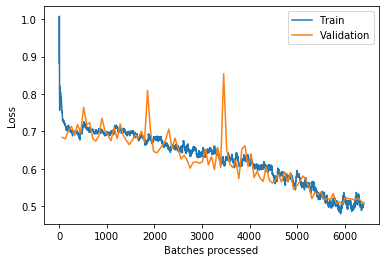

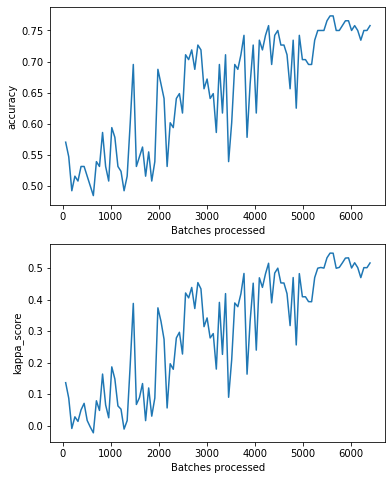

In [26]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
model

In [ ]:
import math
math.sqrt(4096)

In [27]:
obj = learn.validate()

In [28]:
obj

[0.5066348, tensor(0.7578), tensor(0.5159)]